# Clustering
Unsupervised machine learning.

Links
* [Tutorial](https://matteucci.faculty.polimi.it/Clustering/tutorial_html/index.html) from Italy
* [sklearn](https://scikit-learn.org/stable/modules/clustering.html) index of all algorithms
* [sklearn](https://scikit-learn.org/stable/auto_examples/cluster/plot_cluster_comparison.html) comparison on toy datasets

In [1]:
import time
import warnings

import numpy as np
import matplotlib.pyplot as plt

from sklearn import cluster, datasets, mixture
from sklearn.neighbors import kneighbors_graph
from sklearn.preprocessing import StandardScaler
from itertools import cycle, islice

#np.random.seed(0)

In [2]:
n_samples = 1500
noisy_circles = datasets.make_circles(n_samples=n_samples, factor=0.5, noise=0.05)
noisy_moons = datasets.make_moons(n_samples=n_samples, noise=0.05)
blobs = datasets.make_blobs(n_samples=n_samples, random_state=8)
no_structure = np.random.rand(n_samples, 2), None

In [3]:
COLORS = np.array([
                            "#377eb8",
                            "#ff7f00",
                            "#4daf4a",
                            "#f781bf",
                            "#a65628",
                            "#984ea3",
                            "#999999",
                            "#e41a1c",
                            "#dede00"
])

## Hierarchical clustering
Agglomerative = bottom-up. Scales well. Works with any distance, even non-Euclidean. Can choose #clusters interactively.  

Clustering metrics: single-linkage clustering (min), complete-linkage clustering (max), average-linkage clustering. Ward uses centroids and SSE; it is similar to ANOVA and to the K-means objective function in that it minimizes intra vs inter group variance.

See: [sklearn](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.AgglomerativeClustering.html#sklearn.cluster.AgglomerativeClustering) AgglomerativeClustering. Can set goal by #clusters or distance threshold. Attributes include #clusters, #leaves, #features used, and #connected components.    
See also: [sklearn](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.FeatureAgglomeration.html#sklearn.cluster.FeatureAgglomeration) FeatureAgglomeration can cluster features for dimensionality reduction.

In [18]:
def make_clusters(XY, num_clusters=None):
    X = XY[0]
    Y = XY[1]
    alg = cluster.AgglomerativeClustering()
    if num_clusters is not None:
        alg = cluster.AgglomerativeClustering(num_clusters)  
        ## with no setting, it converges on 2
    alg.fit(X)
    ypred = alg.labels_
    print('#clusters',alg.n_clusters_,'cluster assignments per point',alg.labels_)
    plt.scatter(X[:, 0], X[:, 1], color=COLORS[ypred])
    plt.show()

#clusters 2 cluster assignments per point [1 1 1 0 0 0]


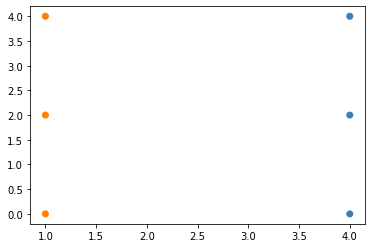

In [20]:
# Simple example from docs with 2 clusters obviously.
X = np.array([[1, 2], [1, 4], [1, 0], [4, 2], [4, 4], [4, 0]])
Y = [0,0,0,1,1,1]
make_clusters( (X,Y) )

#clusters 2 cluster assignments per point [0 0 1 ... 0 0 0]


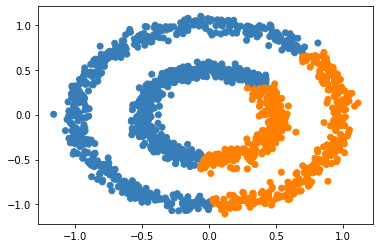

In [22]:
make_clusters(noisy_circles)

#clusters 3 cluster assignments per point [2 2 2 ... 2 1 1]


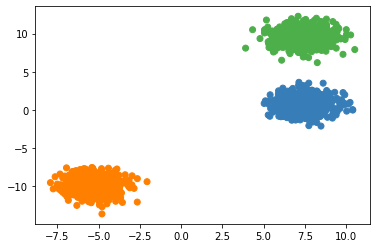

In [23]:
make_clusters(blobs,3)  # better than 2

#clusters 5 cluster assignments per point [4 3 0 ... 1 2 1]


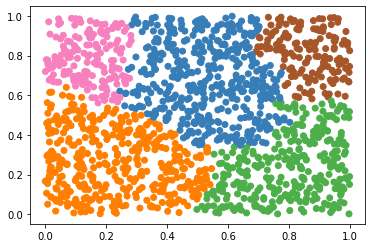

In [24]:
make_clusters(no_structure,5)

## Partition clustering
K-Means Clustering  
[sklearn](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html?highlight=kmeans#sklearn.cluster.KMeans) Kmeans

In [38]:
def make_clusters(XY, num_clusters=None):
    X = XY[0]
    Y = XY[1]
    alg = cluster.KMeans()  # default = 8
    if num_clusters is not None:
        alg = cluster.KMeans(num_clusters)  
    alg.fit(X)
    ypred = alg.labels_
    print('iterations',alg.n_iter_,',cluster centers:\n',alg.cluster_centers_)
    print('cluster assignments per point',alg.labels_)
    print('SSE (optionally weighted)',alg.inertia_)
    plt.scatter(X[:, 0], X[:, 1], color=COLORS[ypred])
    plt.show()

iterations 11 ,cluster centers:
 [[0.7315586  0.77714147]
 [0.15701871 0.25465802]
 [0.24133952 0.74812082]
 [0.5174664  0.27329375]
 [0.84969523 0.26248598]]
cluster assignments per point [0 2 0 ... 3 0 1]
SSE (optionally weighted) 52.30894480205968


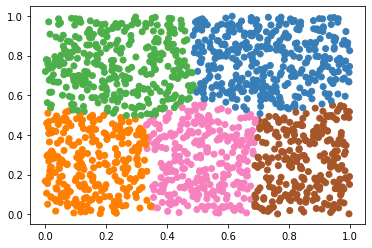

In [39]:
make_clusters(no_structure,5)

iterations 18 ,cluster centers:
 [[0.53537622 0.14556891]
 [0.44714357 0.51330322]
 [0.14247625 0.25164591]
 [0.74468141 0.80137289]
 [0.20596627 0.79403916]
 [0.84381488 0.29793338]]
cluster assignments per point [3 4 3 ... 1 3 2]
SSE (optionally weighted) 43.993323874879415


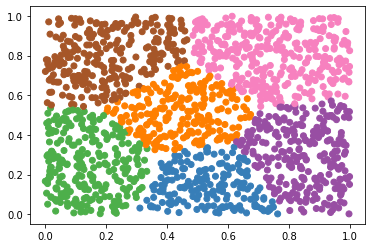

In [40]:
make_clusters(no_structure,6)